# Credit Card Fraud Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Fraudulent Transactions**_

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Imbalanced data problem](#Imbalanced_data_problem)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)

## Background



Identifying Credit Card Fraudulent transaction is crucial to the banking business to protect their customers from fraud. Identifying fraud transactions is not an easy task and it can consume a lot of auditors time to identify those transactions and it can delay the purchasing of whatever items the card holder wants to purchase.

In this notebook, I will demonstrate how to build an binary classification model to predict whether a specific credit card transaction is genuine of fraud. I will use Sagemaker's implementation of XGBoost algorithm.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.3f}'.format
# pd.set_option('display.max_columns', 500)

---
## Data


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset we use is publicly available at https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [2]:
!ls ../../data

credit_filtered.csv creditcardfraud.zip kc_house_data.csv   telecom_churn.csv
creditcard.csv      gm_2008_region.csv  mnist_digits.csv


In [3]:
import pandas as pd

credit_df = pd.read_csv('../../data/creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


# Exploratory Data Analysis

### 1- Get The Dataframe Summary

Looks like the ```Time``` and ```Amount``` features need scaling

In [4]:
# Summarize the credit_df dataframe after scaling
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


### 2- Checking The Balance of The Data

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [5]:
print('The number of Non-Frauds are: ' + str(credit_df['Class'].value_counts()[0]) + ' which is ', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(credit_df['Class'].value_counts()[1]) + ' which is ', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')


The number of Non-Frauds are: 284315 which is  99.83 % of the dataset
The number of Frauds are: 492 which is  0.17 % of the dataset


#### Plot the Class Distribution

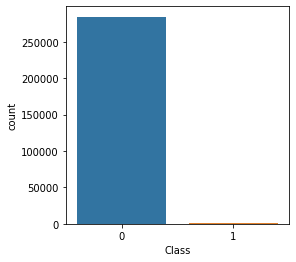

In [6]:
plt.figure(figsize=(4, 4))
sns.countplot('Class', data=credit_df);

### 3- Checking Missing Data

If there are any missing data in our dataset, we need to deal with them before training. Data Imputation is a critical step in the Feature Engineering phase.

In [7]:
credit_df.isna().sum().any()

False

# Feature Engineering

### 1- Fixing The Feature Scaling Problem For (Time and Amount)

In [8]:
# Since most of our data has already been scaled 
# we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import RobustScaler

# RobustScaler is robust to outliers.
credit_df['amount_after_scaling'] = RobustScaler().fit_transform(credit_df['Amount'].values.reshape(-1,1))
credit_df['time_after_scaling'] = RobustScaler().fit_transform(credit_df['Time'].values.reshape(-1,1))

In [9]:
credit_df.drop(['Time','Amount'], axis=1, inplace=True)

In [10]:
y = credit_df['Class']
X_all = credit_df.drop(['Class'], axis=1)

# Place the class in the begining of the dataframe
credit_df.drop(['Class'], axis=1, inplace=True)
credit_df.insert(0, 'Class', y)

In [11]:
credit_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,0.002,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.927,0.119
std,0.042,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,3.495,0.558
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,-0.307,-0.995
25%,0.000,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,-0.229,-0.358
50%,0.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,0.000,0.000
75%,0.000,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,0.771,0.642
max,1.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,358.683,1.035


We can see immediately that:
- `time_after_scaling` appears to be quite evenly distributed and scaled with min and max values are within the range of the other features
- `amount_after_scaling` transaction amount values are also scaled to be within the range of the other features with min of -0.307 and max of 358.68

## Clear outliers (to be done...)

# Imbalanced_data_problem

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Always split into test and train sets BEFORE trying oversampling techniques! 

### Train-test split

In [12]:
y = credit_df['Class']
X_all = credit_df.drop(columns=['Class'])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, stratify=y, random_state=1)

imbalanced_test_X, imbalanced_test_y = X_test, y_test

In [14]:
# no balancing

X_to_train = X_train.copy()
y_to_train = y_train.copy()

# roc_auc 0.927
# recall 0.854
# accuracy 1.000

# roc_auc 0.898
# recall 0.797
# accuracy 1.000

### 2- Fix the target feature imbalance problem (Resampling)


#### Undersampling The Class Feature

In [15]:

# roc_auc 0.955
# recall 0.935
# accuracy 0.976

# roc_auc 0.934
# recall 0.894
# accuracy 0.973

#### Simple oversampling

In [16]:

# roc_auc 0.985
# recall 0.976
# accuracy 0.995

#### Oversampling The Class Feature with SMOTE

In [17]:

# roc_auc 0.954
# recall 0.919
# accuracy 0.989

#### Use specific algo that adresses the problem of imbalanced data

In [18]:
# BalancedBaggingClassifier
# roc_auc 0.948
# recall 0.919
# accuracy 0.977

#### Use novelty detection approach

In [19]:
# IsolationForest()
# roc_auc 0.926
# recall 0.951
# accuracy 0.902

# adjusted boundary
# roc_auc 0.780
# recall 0.569
# accuracy 0.990

# LocalOutlierFactor
# roc_auc 0.685
# recall 0.472
# accuracy 0.898

## Use novelty detection approach

In [24]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [25]:
X_to_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
16375,0.880,-0.218,0.382,1.423,-0.316,0.061,0.122,0.091,0.014,-0.009,...,0.034,0.027,-0.153,0.236,0.560,-0.355,0.014,0.028,1.453,-0.669
85974,1.200,0.288,0.406,0.628,-0.440,-0.872,-0.034,-0.052,-0.194,-0.105,...,-0.226,-0.705,0.146,0.487,0.148,0.065,-0.029,0.022,-0.289,-0.278
139350,0.829,-1.109,0.784,0.221,-1.281,0.166,-0.604,0.250,1.148,-0.331,...,-0.106,-0.570,-0.122,0.058,0.037,0.930,-0.082,0.031,2.431,-0.019
74718,-0.382,1.557,0.003,0.814,0.220,-1.173,0.972,-0.267,-0.035,0.939,...,0.088,0.543,0.056,0.384,-0.628,-0.418,0.513,0.349,-0.273,-0.340
137134,1.269,-1.304,0.276,-1.425,-1.350,-0.248,-0.923,-0.008,-2.170,1.535,...,-0.079,-0.040,-0.033,-0.000,0.273,-0.197,0.022,0.021,1.111,-0.031


In [26]:
inliers_indices = y_to_train == 0

y_0 = y_to_train[inliers_indices]
X_0 = X_to_train[inliers_indices]

y_0.value_counts()

0    213236
Name: Class, dtype: int64

In [27]:
y_to_train.value_counts()

0    213236
1       369
Name: Class, dtype: int64

In [28]:
# IsolationForest()
# roc_auc 0.926
# recall 0.951
# accuracy 0.902

# model = OneClassSVM()

# model = LocalOutlierFactor()



In [29]:
# model = IsolationForest()
# model = OneClassSVM()
# model = LocalOutlierFactor()

In [30]:
from sklearn.preprocessing import Normalizer

nm = Normalizer().fit(X_0)
X_0_norm = nm.transform(X_0)

In [38]:
model = IsolationForest()
model.fit(X_0)

/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [32]:
X_test_norm = nm.transform(X_test)

In [39]:
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred = y_pred.replace(to_replace={-1:2, 1:0})
y_pred = y_pred.replace(to_replace={2:1})

/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [34]:
np.unique(y_pred, return_counts=True)
# (array([-1,  1]), array([ 7113, 64089]))

(array([0, 1]), array([64072,  7130]))

## Train and evaluate

In [35]:
# from xgboost import XGBClassifier

# clf = XGBClassifier(random_state=1).fit(X_to_train, y_to_train)
# y_pred = clf.predict(imbalanced_test_X)

In [36]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score

In [18]:
imbalanced_test_y.shape

(71202,)

In [22]:
y_pred = np.ones_like(imbalanced_test_y) 
condition = np.where(imbalanced_test_y == 1)[0]
y_pred[condition] = 0

In [40]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score

print("roc_auc %.3f" % roc_auc_score(imbalanced_test_y, y_pred))
print("recall %.3f" % recall_score(imbalanced_test_y, y_pred))
print("accuracy %.3f" % accuracy_score(imbalanced_test_y, y_pred))


roc_auc 0.922
recall 0.943
accuracy 0.901


In [ ]:
# from sklearn.svm import SVC
# sclf = SVC().fit(X_to_train, y_to_train)

# roc_auc 0.947
# recall 0.919
# accuracy 0.975

### Conclusion
*dealing with imbalanced datasets:*
 - Change the performance metric
 - Change the algorithm
 - Oversample minority class
 - Undersample majority class
 - Generate synthetic samples
 - Use novelty detection methods